In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb
import time
os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=1,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=64)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.133:40819,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [5]:
# Validation Budget
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep1.nc').chunk('auto').__xarray_dataarray_variable__

st_ocean_holder=anth_dic_cafe.st_ocean

l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)

st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

anth_dic_cafe=anth_dic_cafe*st_ocean_holder.depth_diff #Cell weighted depth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

tot_anth_dic_cafe=anth_dic_cafe*area_m2/1000 #mol anthC (m3 is now cancelled)

In [6]:
anth_dic_cafe

<xarray.DataArray (time: 731, st_ocean: 50, lat: 140, lon: 170)>
dask.array<mul, shape=(731, 50, 140, 170), dtype=float64, chunksize=(87, 50, 70, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat         (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0

In [7]:
# Is the Amount of anth C accumulated in the box over the 20 years. (mmol anth C)
tot_anth_dic_cafe=anth_dic_cafe*area_m2/1000
diff=tot_anth_dic_cafe.sel(time='2020-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values-\
    tot_anth_dic_cafe.sel(time='2000-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values# Total mol anthC 
print(diff)

65374885807938.28


In [8]:
(diff*12)/1e15 #Petagrams total change

0.7844986296952594

In [9]:
#Total ADIC in the box
(tot_anth_dic_cafe.sel(time='2020-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values*12)/1e15

2.820181403432957

In [10]:
# Calculate total DIC in the box at 2020-01-01 and 2020-01-01
# And then calculate total transport through each of the faces. 

In [11]:
(tot_anth_dic_cafe.sel(time='2000-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,600)).sum().values*12)/1e15

2.0356827737376975

In [12]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [13]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [14]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


run_depths=False #Turn to false after proces
if run_depths==True:
    upwelling_cafe_100=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-100,method='nearest') #
    upwelling_cafe_300=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-300,method='nearest') #
    upwelling_cafe_500=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-500,method='nearest') #
    upwelling_cafe_600=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-600,method='nearest') #
    upwelling_cafe_900=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-900,method='nearest') #

    upwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_600=(upwelling_cafe_600.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-600,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_600=(upwelling_cafe_600.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-600,method='nearest')*area_m2)#/1e6 # To Sverdrups

    upwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups
    print('Saving')
    upwelling_100.to_netcdf('../processed_data/upwelling_through_layers/upwelling100.nc')
    upwelling_300.to_netcdf('../processed_data/upwelling_through_layers/upwelling300.nc')
    upwelling_500.to_netcdf('../processed_data/upwelling_through_layers/upwelling500.nc')
    upwelling_600.to_netcdf('../processed_data/upwelling_through_layers/upwelling600.nc')
    upwelling_900.to_netcdf('../processed_data/upwelling_through_layers/upwelling900.nc')
    print('Saving2')
    anthupwelling_100.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling100.nc')
    anthupwelling_300.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling300.nc')
    anthupwelling_500.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling500.nc')
    anthupwelling_600.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling600.nc')
    anthupwelling_900.to_netcdf('../processed_data/upwelling_through_layers/anthupwelling900.nc')

    
upwelling_100=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling100.nc').__xarray_dataarray_variable__
upwelling_300=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling300.nc').__xarray_dataarray_variable__
upwelling_500=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling500.nc').__xarray_dataarray_variable__
upwelling_600=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling600.nc').__xarray_dataarray_variable__
upwelling_900=xr.open_dataset('../processed_data/upwelling_through_layers/upwelling900.nc').__xarray_dataarray_variable__
anthupwelling_100=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling100.nc').__xarray_dataarray_variable__
anthupwelling_300=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling300.nc').__xarray_dataarray_variable__
anthupwelling_500=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling500.nc').__xarray_dataarray_variable__
anthupwelling_600=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling600.nc').__xarray_dataarray_variable__
anthupwelling_900=xr.open_dataset('../processed_data/upwelling_through_layers/anthupwelling900.nc').__xarray_dataarray_variable__

   

anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# EVERYTHING SHOULD BE IN MMOL/S

In [15]:
upwelling_100

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, lat: 140, lon: 170)>
[17397800 values with dtype=float64]
Coordinates:
    ensemble  int32 ...
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [16]:
ls ../processed_data/upwelling_through_layers

anth_lowerthermocline_to_thermostad.nc  lowerthermocline_to_thermostad.nc
anth_surface_to_upperthermocline.nc     surface_to_upperthermocline.nc
anth_upper_to_lowerthermocline.nc       upper_to_lowerthermocline.nc
anthupwelling100.nc                     upwelling100.nc
anthupwelling300.nc                     upwelling300.nc
anthupwelling500.nc                     upwelling500.nc
anthupwelling600.nc                     upwelling600.nc
anthupwelling900.nc                     upwelling900.nc


In [17]:
cafe_x_tx

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [18]:
# mmol/s
#10^9 kg/s

In [19]:
# Compare Area vs Transport??

In [20]:
#area_m2/1e6

### Check some of the vars to make sure they look ok

In [21]:
cafe_x_tx

#mmol/m3 * 1e9 KG/S (/1e6?)

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [22]:
adic_cafe

<xarray.DataArray 'adic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [23]:
dic_cafe

<xarray.DataArray 'dic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [24]:
cafe_co2_anth

<xarray.DataArray (time: 720, lat: 140, lon: 170)>
array([[[-8.12692815e-05, -8.05905293e-05, -8.20420464e-05, ...,
                     nan,             nan,             nan],
        [-6.27744885e-05, -6.36629266e-05, -6.60276419e-05, ...,
                     nan,             nan,             nan],
        [-4.99513044e-05, -5.13415143e-05, -5.46429619e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan, -2.59818335e-05, -3.11375188e-05, ...,
         -1.01243699e-04, -1.02947000e-04, -1.06701322e-04],
        [-1.92235748e-05, -3.19972460e-05, -3.46961024e-05, ...,
         -9.25098793e-05, -9.91586639e-05, -1.05985877e-04],
        [-2.11526640e-05, -3.40708648e-05, -3.36802186e-05, ...,
         -7.62597265e-05, -9.34339914e-05, -1.00215228e-04]],

       [[-4.17797819e-05, -3.93452137e-05, -3.69605914e-05, ...,
                     nan,             nan,             nan],
        [-4.07274892e-05, -3.91482645e-05, -3.71795686e-05, ...,
                     nan,             nan,             nan],
        [-4.05038336e-05, -3.78398254e-05, -3.61938655e-05, ...,
                     nan,             nan,             nan],
...
          4.58130380e-05,  3.81436475e-05,  3.83082443e-05],
        [ 6.15766112e-06,  1.95439279e-05,  2.09899772e-05, ...,
          7.02108446e-05,  6.37502671e-05,  5.76455386e-05],
        [ 1.10565015e-05,  2.25717340e-05,  2.25512740e-05, ...,
          6.59838988e-05,  6.79772347e-05,  7.34023342e-05]],

       [[-2.02712654e-05, -2.05903052e-05, -2.09384380e-05, ...,
                     nan,             nan,             nan],
        [-2.01107614e-05, -2.07197882e-05, -2.07053963e-05, ...,
                     nan,             nan,             nan],
        [-1.64308076e-05, -1.72205873e-05, -1.79971030e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,  3.39869730e-05,  3.90992282e-05, ...,
          8.11240679e-05,  6.95347044e-05,  6.75038245e-05],
        [ 1.60184063e-05,  3.96328105e-05,  4.29397187e-05, ...,
          1.07914566e-04,  9.74847426e-05,  9.13539479e-05],
        [ 1.96226829e-05,  4.13808593e-05,  4.16727489e-05, ...,
          1.01620652e-04,  1.07105065e-04,  1.12273679e-04]]],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

## Key Tracer Calculation and Save. 

In [21]:
# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers=False
if calculate_horizontal_tracers==True:
    names=['anth_dic_cafe','dic_cafe']
    for i,tracer in enumerate([anth_dic_cafe,dic_cafe]):
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx
            tracer_v_tx=tracer_v_interp*cafe_y_tx

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport.nc')
        print('v saved')
        
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK
test=False
if test==True:
    #chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
    anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')

In [22]:
#cafe_y_tx_gm.sel(time='2010-01-01',lat_x=3,lon=180,method='nearest').plot()

In [23]:
calculate_horizontal_tracers_gm=False
if calculate_horizontal_tracers_gm==True:
    names=['dic_cafe']  #anth_dic_cafe
    for i,tracer in enumerate([dic_cafe]):# anth_dic_cafe
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx_gm
            tracer_v_tx=tracer_v_interp*cafe_y_tx_gm

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport_gm.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport_gm.nc')
        print('v saved')
        
#anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

## Calculate ENSO Months

In [24]:
#anth_dic_u_tx

In [25]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [26]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(inputds,enso_months,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True,run_density_calc=True,lat=None,lon=None):
    ds=inputds.sel(time=enso_months).mean(dim='time')#.copy(deep=True)
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18 # From Seconds to Minute to Hour to Day to Year to Milligrams to Petagrams
           
        
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    res=[pos.sum().values,neg.sum().values]
    #if mean==True:
    #    res=[pos.mean().values,neg.mean().values]
    #elif mean==False:
        
        # PROBABLY NEED TO MASK THIS TO SURFACE DENSITY LAYER SO WE KIND OF GET SURFACE AND EUC FLOW. 
    
        
    if printer==True:
        print(f'Postive and negative sums {np.array(res)}')
        print(f'Total Sum {ds.sum().values}')
        #print(f'Total Sum Surface {ds.sel(st_ocean=slice(0,-100)).sum().values}')
        
        print(ds1.where(ds1>0).mean().values)
        try:
            print(density_tx.T)
        except:
            pass #Name Error?
    
    # MASK
    if run_density_calc==True:

        # NEED TO GET THE LAT OR LON FOR THE DENS BOX...
        density_timefix=cafe_potential_density.sel(time=enso_months).mean(dim='time')
        if lat is not None:
            density_timefix=density_timefix.sel(lat=lat,method='nearest')
        if lon is not None:
            density_timefix=density_timefix.sel(lon=lon,method='nearest')
            
        

        above_thermostad=ds.where((density_timefix.chunk('auto')<=1026.6))
        pos_above_thermostad=above_thermostad.where(ds>cutoff)
        neg_above_thermostad=above_thermostad.where(ds<-cutoff)
        res_above_thermostad=[pos_above_thermostad.sum().values,neg_above_thermostad.sum().values]

        #above_thermocline=ds.where((density_timefix.chunk('auto')<=1024.5))
        #pos_above_thermocline=above_thermocline.where(ds>cutoff)
        #neg_above_thermocline=above_thermocline.where(ds<-cutoff)
        #res_above_thermocline=[pos_above_thermocline.mean().values,neg_above_thermostad.mean().values]

            
            
            
            
            
        surface=ds.where(density_timefix.chunk('auto')<=1024.5)
        #upperthermocline=ds.where((density_timefix.chunk('auto')>=1023)&(density_timefix.chunk('auto')<1024.5))
        lowerthermocline=ds.where((density_timefix.chunk('auto')>=1024.5)&(density_timefix.chunk('auto')<1026.3))
        thermostad=ds.where((density_timefix.chunk('auto')>=1026.3))
        #print(surface)
        #print(surface.sum())
        surface_sum=surface.sum().values
        #upperthermocline_sum=upperthermocline.sum().values
        lowerthermocline_sum=lowerthermocline.sum().values
        thermostad_sum=thermostad.sum().values

        
        # OK Maybe actually just rewrite the surface and upper versions and replace them with Positive and negative sums above SURFACE density and BOTTOM EUC density
        density_tx=pd.DataFrame({'surface_sum':surface_sum,
                      #'upperthermocline_sum':upperthermocline_sum,
                      'lowerthermocline_sum':lowerthermocline_sum,
                      'thermostad_sum':thermostad_sum,
                      'Total Sum':ds.sum().values      ,    
                      'Total Sum 100m':ds.sel(st_ocean=slice(0,-100)).sum().values,
                      'Positive Sum':res[0],
                      'Negative Sum':res[1],
                      
           #           'Positive Sum above thermocline':res_above_thermocline[0],#res[0],
           #           'Negative Sum  above thermocline':res_above_thermocline[1],#res[1]},
                      
                      'Positive Sum above thermostad':res_above_thermostad[0],#res[0],
                      'Negative Sum above thermostad':res_above_thermostad[1]},#res[1]},
                      #'Positive Sum':res[0],
                      #'Negative Sum':res[1]},
                                          
                        index=[0])

        return density_tx#np.array(res)
    else:
        return res

In [27]:
#cafe_potential_density.sel(time=neutral_events).mean(dim='time').chunk('auto')

In [28]:
#anth_dic_v_tx.sel(st_ocean=slice(0,-100))

In [29]:
# Regrid at least the u and v componetns to the density grid.
anth_dic_v_tx=anth_dic_v_tx.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')
dic_v_tx=dic_v_tx.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')

anth_dic_u_tx=anth_dic_u_tx.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')
dic_u_tx=dic_u_tx.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')


In [30]:
dic_transport_through_box=pd.DataFrame()

In [31]:
#test
test=False
if test==True:
    enso_mont=nina_events
    cpd=cafe_potential_density.chunk('auto').sel(time=enso_mont).mean(dim='time')
    t_ex=(anth_dic_v_tx.chunk('auto').sel(time=enso_mont).mean(dim='time')*60*60*24*12*365)/1e18
    surface=t_ex.where((cpd.chunk('auto')<1023))
    upperthermocline=t_ex.where((cpd.chunk('auto')>=1023)&(cpd.chunk('auto')<1024.5))
    lowerthermocline=t_ex.where((cpd.chunk('auto')>=1024.5)&(cpd.chunk('auto')<1026.3))
    thermostad=t_ex.where((cpd.chunk('auto')>=1026.3))
    print(surface.sel(lat=-3,method='nearest').sum().values)
    print(upperthermocline.sel(lat=-3,method='nearest').sum().values)
    print(lowerthermocline.sel(lat=-3,method='nearest').sum().values)
    print(thermostad.sel(lat=-3,method='nearest').sum().values)

In [36]:
#upperthermocline.sel(lat=-3,method='nearest').plot()
#lowerthermocline.sel(lat=-3,method='nearest').plot()

# Start the Figures

### Plot 1 and 2: North and South Faces

In [37]:
#client#.restart()

In [38]:
cluster

In [39]:
#densitylevs=[1022,1024.5,1026.7]#6.9]
#(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

Postive and negative sums [ 0.6867668 -0.8787095]
Total Sum -0.19194269180297852
850806.1


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.6939478 -1.057394 ]
Total Sum -0.3634462058544159
770481.06


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.7186141 -1.0163505]
Total Sum -0.29773634672164917
871866.56


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.7003672  -0.88018185]
Total Sum -0.17981457710266113
1014086.6


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.6829749  -0.89542186]
Total Sum -0.21244701743125916
867250.94
Postive and negative sums [ 0.980783  -0.7858573]
Total Sum 0.19492563605308533
1283020.8


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.9447663  -0.79238534]
Total Sum 0.15238098800182343
1145196.5


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.9720438 -0.7693732]
Total Sum 0.202670618891716
1218505.1


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.0893251 -0.8248465]
Total Sum 0.2644786834716797
1643930.9


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.0015337  -0.78569525]
Total Sum 0.21583834290504456
1352343.1


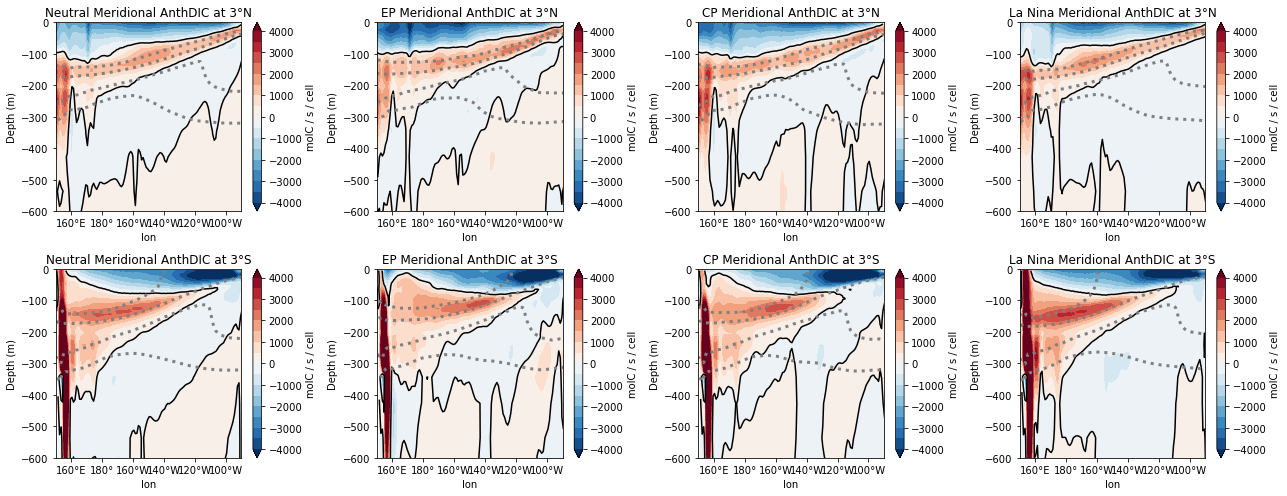

Postive and negative sums [ 30.726313 -36.18504 ]
Total Sum -5.4587249755859375
39338060.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 31.796509 -39.983593]
Total Sum -8.187085151672363
36045356.0


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 33.255547 -40.995224]
Total Sum -7.739676475524902
41431972.0


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 31.53559 -38.74262]
Total Sum -7.207032203674316
47919630.0


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 30.097748 -36.60012 ]
Total Sum -6.502370357513428
40474692.0
Postive and negative sums [ 42.311024 -34.03084 ]
Total Sum 8.280184745788574
56212240.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 39.79327  -32.911854]
Total Sum 6.8814191818237305
48794908.0


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 43.115158 -32.933388]
Total Sum 10.181766510009766
54774550.0


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 47.271408 -37.41217 ]
Total Sum 9.859235763549805
72246320.0


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 42.899815 -33.999355]
Total Sum 8.900458335876465
59445212.0


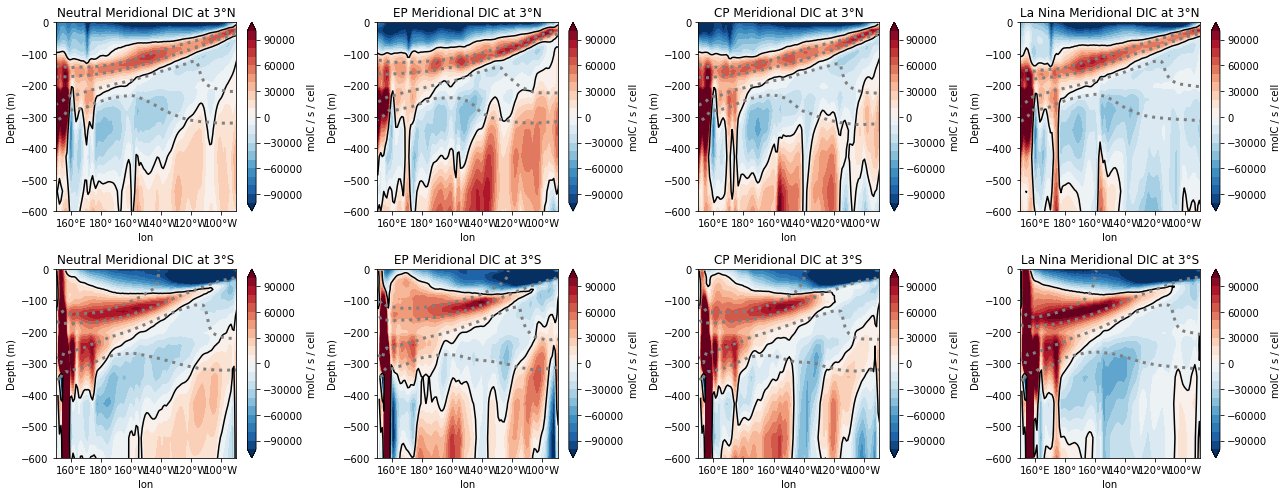

CPU times: user 2min 23s, sys: 32.4 s, total: 2min 56s
Wall time: 24min 2s


,surface_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,Positive Sum above thermostad,Negative Sum above thermostad
Neutral Meridional AnthDIC at 3°N,-0.384297,0.183075,0.009280,-0.191943,-0.570982,0.686767,-0.878709,0.654393,-0.851838
EP Meridional AnthDIC at 3°N,-0.561537,0.180769,0.017322,-0.363446,-0.745824,0.693948,-1.057394,0.657504,-1.024497
CP Meridional AnthDIC at 3°N,-0.506844,0.178549,0.030558,-0.297736,-0.703720,0.718614,-1.016351,0.675503,-0.993122
Nina Meridional AnthDIC at 3°N,-0.363093,0.184857,-0.001579,-0.179815,-0.550286,0.700367,-0.880182,0.671786,-0.852522
Alltime Meridional AnthDIC at 3°N,-0.395665,0.173428,0.009790,-0.212447,-0.591666,0.682975,-0.895422,0.653375,-0.871692
Neutral Meridional AnthDIC at 3°S,-0.157924,0.276075,0.076774,0.194926,-0.550290,0.980783,-0.785857,0.911986,-0.763787
EP Meridional AnthDIC at 3°S,-0.185918,0.253343,0.084956,0.152381,-0.510475,0.944766,-0.792385,0.877855,-0.771734
CP Meridional AnthDIC at 3°S,-0.186368,0.292525,0.096513,0.202671,-0.557410,0.972044,-0.769373,0.896318,-0.750768
Nina Meridional AnthDIC at 3°S,-0.077504,0.280568,0.061415,0.264479,-0.528010,1.089325,-0.824847,1.014381,-0.794788
Alltime Meridional AnthDIC at 3°S,-0.128414,0.266566,0.077686,0.215838,-0.540360,1.001534,-0.785695,0.934076,-0.764063


In [40]:
%%time
longitude_labels=['','160°E','180°','160°W','140°W','120°W','100°W']
densitylevs=[1023,1024.5,1026.3,1026.6]#,1026.7]#,1027.0]#,1026.7,1027,1027.5]
ylim=-600

plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):
        plt.figure(figsize=(18,7))

        for xi,lat in enumerate([3,-3]):
            #Client.restart()
            #time.sleep(10)
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')/1000 #to mol #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==3: 
                direct='3°N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-3: direct='3°S'

            
            
            if ((i==0)|(i==2)): 
                levs=np.arange(-4e3,4.5e3,5e2)
            elif i==1: 
                levs=np.arange(-1e5,1.1e5,1e4)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]
            
         

            subpl=plt.subplot(2,4,1+(xi*4))        
            ax=adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_n*1000,enso_months=neutral_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_neutral.index=[f'Neutral {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            subpl.set_xticklabels(longitude_labels)
            plt.ylabel('Depth (m)')
            
            #cbar=plt.colorbar(ax)
            #cbar.set_label()#, rotation=270)

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_n*1000,enso_months=ep_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_ep.index=[f'EP {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_n*1000,enso_months=cp_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_cp.index=[f'CP {N_S_names[i]} at {direct}']
            plt.title(f'CP {N_S_names[i]} at {direct}')
            subpl.set_xticklabels(longitude_labels)
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_n*1000,enso_months=nina_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_nina.index=[f'Nina {N_S_names[i]} at {direct}']
            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            subpl.set_xticklabels(longitude_labels)
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            
            asum_alltime=xarray_posneg_calc(adic_tx_n*1000,enso_months=all_dates,lat=lat)
            asum_alltime.index=[f'Alltime {N_S_names[i]} at {direct}']
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina,asum_alltime])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
        plt.tight_layout()
        plt.show()
        
dic_transport_through_box                                     

In [41]:
asum_neutral#.index=['hi']

,surface_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,Positive Sum above thermostad,Negative Sum above thermostad
Neutral Meridional DIC at 3°S,-7.704298,11.049176,4.935304,8.280185,-21.992031,42.311024,-34.030842,35.980808,-31.337814


In [42]:
cluster.close()
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=1,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=64)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f50bafdd4c0>>, <Task finished name='Task-28192' coro=<Cluster._sync_cluster_info() done, defined at /g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/deploy/cluster.py:98> exception=CommClosedError("Exception while trying to call remote method 'set_metadata' before comm was established.")>)
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/comm/tcp.py", line 198, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/core.py",

In [43]:
time.sleep(20)

In [44]:
cluster

In [45]:
anth_dic_u_tx

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
dask.array<rechunk-merge, shape=(731, 30, 140, 170), dtype=float32, chunksize=(103, 15, 35, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5

### Plot 3+4: Western and Eastern Faces

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Postive and negative sums [ 0.6289853 -0.3245144]
Total Sum 0.304470956325531
5692064.5
Postive and negative sums [ 0.52658737 -0.38910037]
Total Sum 0.13748691976070404
4732986.0
Postive and negative sums [ 0.6133987  -0.42744258]
Total Sum 0.18595603108406067
5551011.5
Postive and negative sums [ 0.6426511  -0.29713085]
Total Sum 0.3455201983451843
5979557.0
Postive and negative sums [ 0.62087816 -0.32811797]
Total Sum 0.2927601933479309
5677023.0
Postive and negative sums [ 0.11598948 -0.3072051 ]
Total Sum -0.1912156492471695
2339696.0
Postive and negative sums [ 0.15499473 -0.296735  ]
Total Sum -0.14174027740955353
2512704.8
Postive and negative sums [ 0.1462926  -0.28732714]
Total Sum -0.1410345435142517
3451568.5
Postive and negative sums [ 0.10218932 -0.3195793 ]
Total Sum -0.21738998591899872
2231681.8
Postive and negative sums [ 0.11529713 -0.3062026 ]
Total Sum -0.19090548157691956
2874251.8


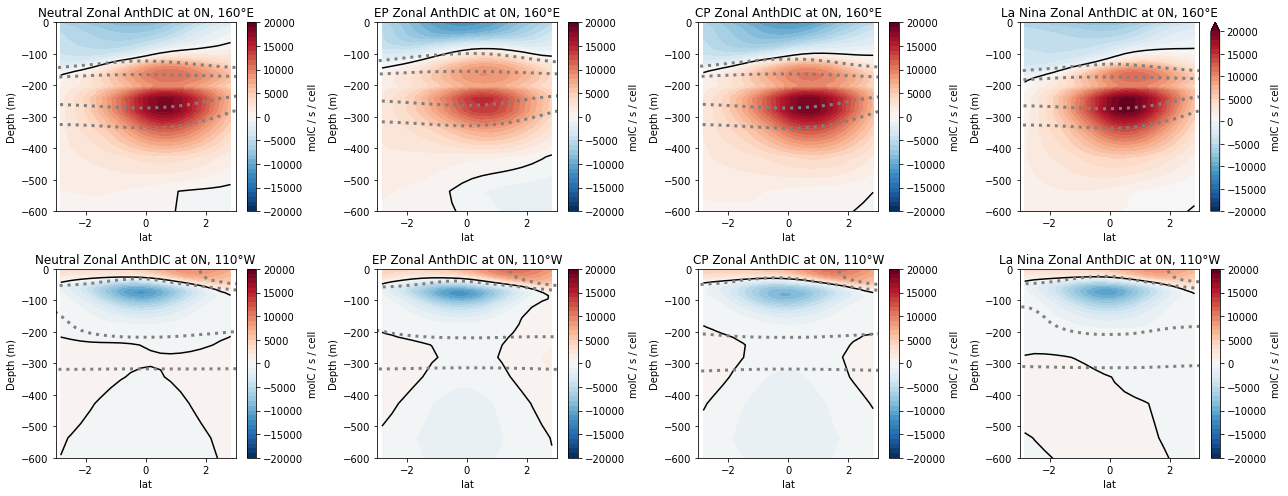

Postive and negative sums [ 29.880878 -11.357615]
Total Sum 18.523265838623047
270409950.0
Postive and negative sums [ 23.35194  -13.696192]
Total Sum 9.655749320983887
212783070.0
Postive and negative sums [ 29.773596 -14.562162]
Total Sum 15.21143627166748
271297280.0
Postive and negative sums [ 32.39911  -10.048145]
Total Sum 22.350967407226562
300400320.0
Postive and negative sums [ 30.047272 -11.279154]
Total Sum 18.76811981201172
275692380.0
Postive and negative sums [  5.307529 -16.167011]
Total Sum -10.859481811523438
114959440.0
Postive and negative sums [  6.520378 -16.564642]
Total Sum -10.04426383972168
111883010.0
Postive and negative sums [  6.007977 -17.185844]
Total Sum -11.177865028381348
140495340.0
Postive and negative sums [  4.302637 -17.33332 ]
Total Sum -13.030685424804688
122254240.0
Postive and negative sums [  4.938867 -16.499758]
Total Sum -11.560890197753906
130508700.0


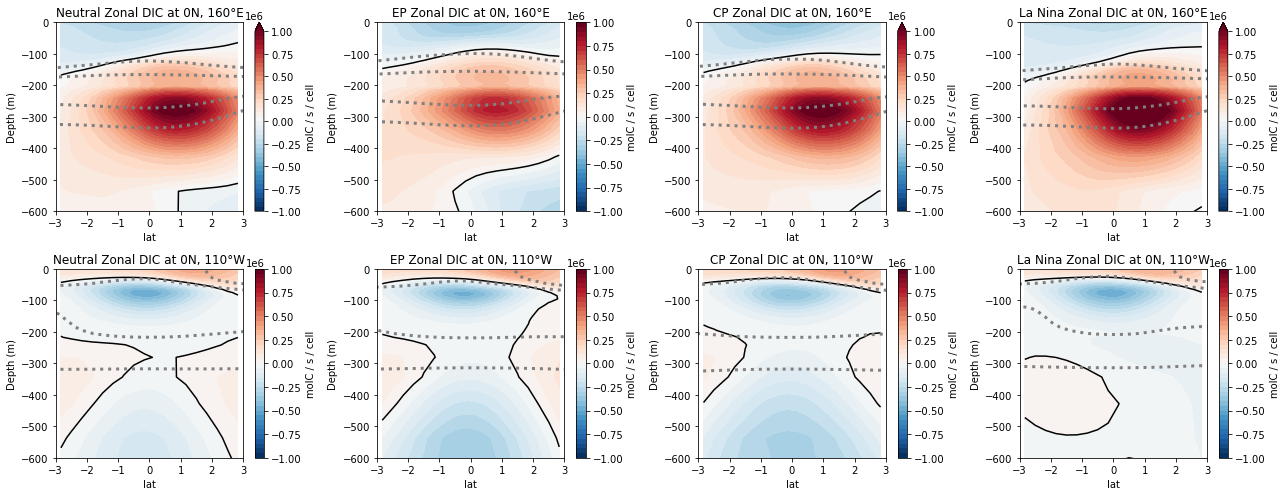

CPU times: user 11min, sys: 6min 42s, total: 17min 42s
Wall time: 14min 11s


In [46]:
%%time

plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lat*(anth_dic_tx_u_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T*-1)] # Wrong Direction

    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):
        #Client.restart()
        #time.sleep(10)
        ylim=-600
        plt.figure(figsize=(18,7))
        lons=[160,250]
        for xi, lon in enumerate(lons):
            if i==0 or i==2:
                levs=np.arange(-2e4,2.1e4,1e3)#None#np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=np.arange(-1e6,1.05e6,5e4)#None#np.arange(-1000,1100,100)
                
            if xi==0: 
                lon_name='160°E'
            elif xi==1:
                lon_name='110°W'
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            
            #lon=180
            lslice=slice(-3,3)

            
            #plt.subplot(251)
            subpl=plt.subplot(2,4,1+(xi*4))

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest').sel(lat=lslice)/1000 #mmol to mol #.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest')#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_b*1000,enso_months=neutral_events,lon=lon)
            asum_neutral.index=[f'Neutral {E_W_names[i]} at {lon_name}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon_name}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            #subpl.set_xticklabels(longitude_labels)
            
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_b*1000,enso_months=ep_events,lon=lon)
            asum_ep.index=[f'EP {E_W_names[i]} at {lon_name}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon_name}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])
            #subpl.set_xticklabels(longitude_labels)
               
            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_b*1000,enso_months=cp_events,lon=lon)
            asum_cp.index=[f'CP {E_W_names[i]} at {lon_name}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon_name}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')
            #subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_b*1000,enso_months=nina_events,lon=lon)
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon_name}')
            asum_nina.index=[f'Nina {E_W_names[i]} at {lon_name}']
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')
            #subpl.set_xticklabels(longitude_labels)

            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            asum_alltime=xarray_posneg_calc(adic_tx_b*1000,enso_months=all_dates,lon=lon)
            asum_alltime.index=[f'Alltime {E_W_names[i]} at {lon_name}']
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina,asum_alltime])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
        plt.tight_layout()
        plt.show()
            #temp_holder

In [47]:
dic_transport_through_box

,surface_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,Positive Sum above thermostad,Negative Sum above thermostad
Neutral Meridional AnthDIC at 3°N,-0.384297,0.183075,0.009280,-0.191943,-0.570982,0.686767,-0.878709,0.654393,-0.851838
EP Meridional AnthDIC at 3°N,-0.561537,0.180769,0.017322,-0.363446,-0.745824,0.693948,-1.057394,0.657504,-1.024497
CP Meridional AnthDIC at 3°N,-0.506844,0.178549,0.030558,-0.297736,-0.703720,0.718614,-1.016351,0.675503,-0.993122
Nina Meridional AnthDIC at 3°N,-0.363093,0.184857,-0.001579,-0.179815,-0.550286,0.700367,-0.880182,0.671786,-0.852522
Alltime Meridional AnthDIC at 3°N,-0.395665,0.173428,0.009790,-0.212447,-0.591666,0.682975,-0.895422,0.653375,-0.871692
Neutral Meridional AnthDIC at 3°S,-0.157924,0.276075,0.076774,0.194926,-0.550290,0.980783,-0.785857,0.911986,-0.763787
EP Meridional AnthDIC at 3°S,-0.185918,0.253343,0.084956,0.152381,-0.510475,0.944766,-0.792385,0.877855,-0.771734
CP Meridional AnthDIC at 3°S,-0.186368,0.292525,0.096513,0.202671,-0.557410,0.972044,-0.769373,0.896318,-0.750768
Nina Meridional AnthDIC at 3°S,-0.077504,0.280568,0.061415,0.264479,-0.528010,1.089325,-0.824847,1.014381,-0.794788
Alltime Meridional AnthDIC at 3°S,-0.128414,0.266566,0.077686,0.215838,-0.540360,1.001534,-0.785695,0.934076,-0.764063


In [87]:
cluster.close()
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=64)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [49]:
time.sleep(20)


### Plot 5+6: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling

flux
anthflux


In [50]:
cluster

In [51]:
%%time
save_new_upwelling_density=False
if save_new_upwelling_density==True:
    upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


    upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
    anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


    surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    print('saving')
    surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc')
    print('saving')
    upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc')
    print('saving')
    lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc')
    print('saving')
    anth_surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc')
    print('saving')
    anth_upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc')
    print('saving')
    anth_lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc')

surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc').__xarray_dataarray_variable__
upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__

anth_surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc').__xarray_dataarray_variable__
anth_upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
anth_lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__


#Dens Calcs for upwelling
#dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__

#dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/upwelling_density.nc').tracer#.__xarray_dataarray_variable__
anth_dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anthupwelling_density.nc').tracer



#dic_w_tx_dens.sel(density=25,method='nearest').mean(dim='time').plot()


CPU times: user 247 ms, sys: 64.2 ms, total: 311 ms
Wall time: 1.28 s


Postive and negative sums [44.13533864 -0.3206619 ]
Total Sum 43.81467674036025
57565087.507472605
Postive and negative sums [45.23184763 -0.46495201]
Total Sum 44.76689562317286
58792116.715585046
Postive and negative sums [48.42848408 -0.26419111]
Total Sum 48.16429297694363
62091911.54811473
Postive and negative sums [45.2909909 -1.1806917]
Total Sum 44.11029919727119
63056195.12322251


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


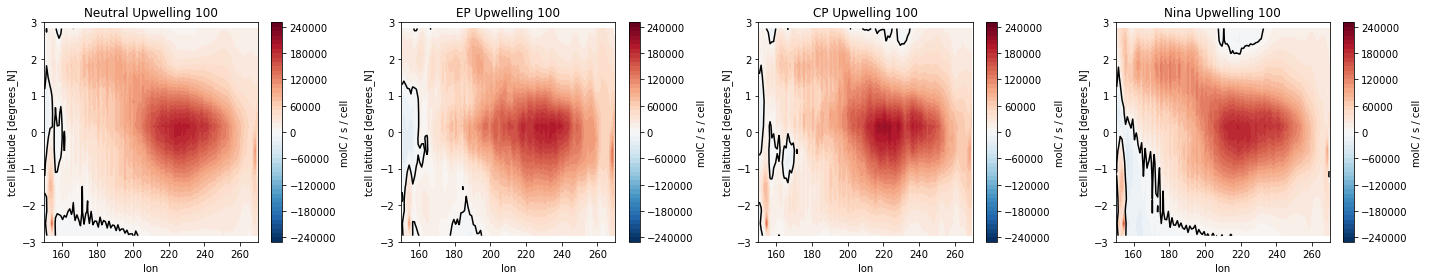

Postive and negative sums [44.82917413 -0.38625579]
Total Sum 44.442918339101126
58789238.47646937
Postive and negative sums [ 1.09946852 -0.00959256]
Total Sum 1.089875953595149
1438280.4422188601
Postive and negative sums [ 1.20404067 -0.01198344]
Total Sum 1.1920572371648723
1551270.8948383583
Postive and negative sums [ 1.22724586 -0.0087326 ]
Total Sum 1.2185132555992941
1574260.1493245175
Postive and negative sums [ 1.10838545 -0.03079446]
Total Sum 1.0775909908250938
1534253.192126908


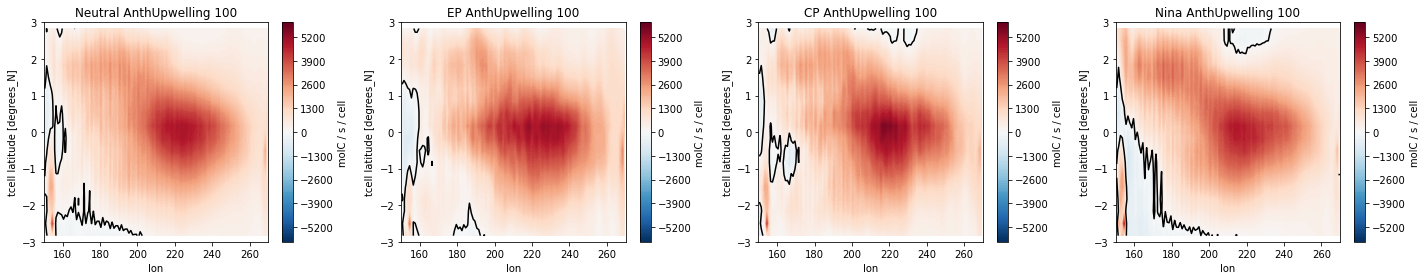

Postive and negative sums [ 1.11808955 -0.0108707 ]
Total Sum 1.1072188492349568
1464089.3226724158
Postive and negative sums [ 4.06036419 -0.45552565]
Total Sum 3.6048385390765647
6345027.783066951
Postive and negative sums [ 8.81649136 -0.39713064]
Total Sum 8.41936072813806
12465182.236838361
Postive and negative sums [ 5.57749921 -0.38373997]
Total Sum 5.193759247640583
7928157.60625742
Postive and negative sums [ 3.20589361 -0.26462394]
Total Sum 2.9412696707797625
4571785.375282658


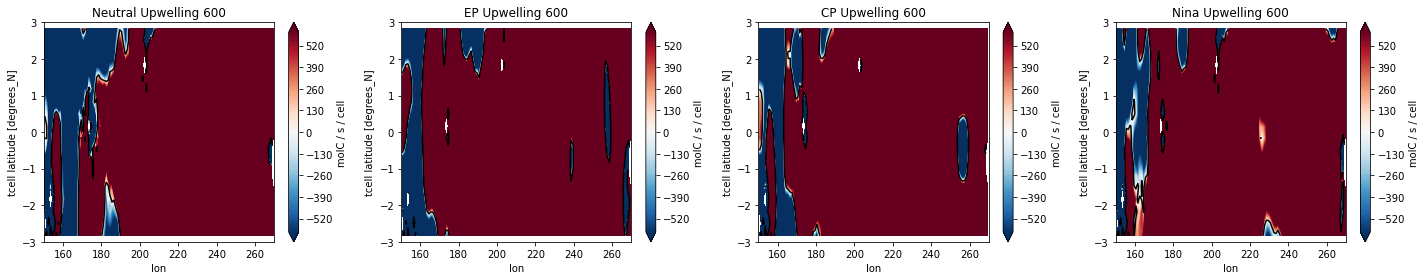

Postive and negative sums [ 4.23327685 -0.30573056]
Total Sum 3.927546293135848
6197429.751044678
Postive and negative sums [ 0.02353397 -0.00438469]
Total Sum 0.019149278180939464
36884.99281533228
Postive and negative sums [ 0.04861143 -0.00399869]
Total Sum 0.044612744760730134
69623.23219314456
Postive and negative sums [ 0.0344051  -0.00405913]
Total Sum 0.03034596488494063
49626.02410020428
Postive and negative sums [ 0.02022638 -0.00305858]
Total Sum 0.017167803232535663
29174.59817040197


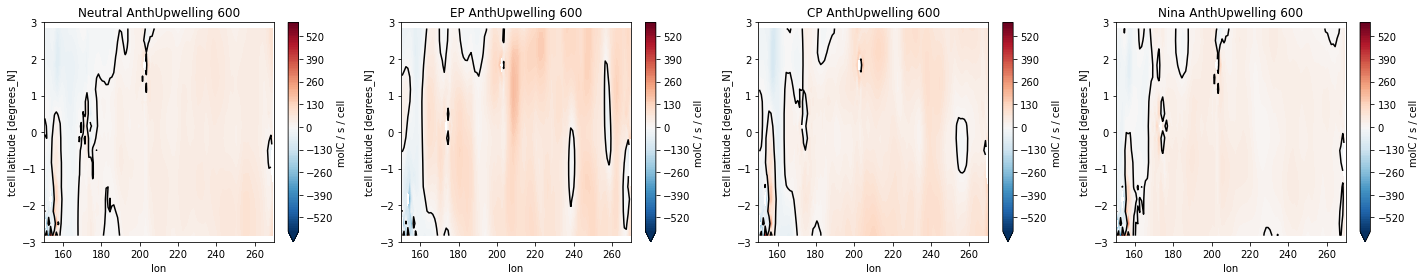

Postive and negative sums [ 0.02499959 -0.00333688]
Total Sum 0.021662709688420066
37071.252458749965
Postive and negative sums [30.47976148 -0.14083883]
Total Sum 30.338922652414702
38610853.96250131
Postive and negative sums [34.7276565  -0.09480541]
Total Sum 34.6328510940826
43886767.2478966
Postive and negative sums [35.4296534  -0.05535957]
Total Sum 35.37429383285797
43646734.2397831
Postive and negative sums [32.781029   -0.18447272]
Total Sum 32.596556275245156
42131955.68114492


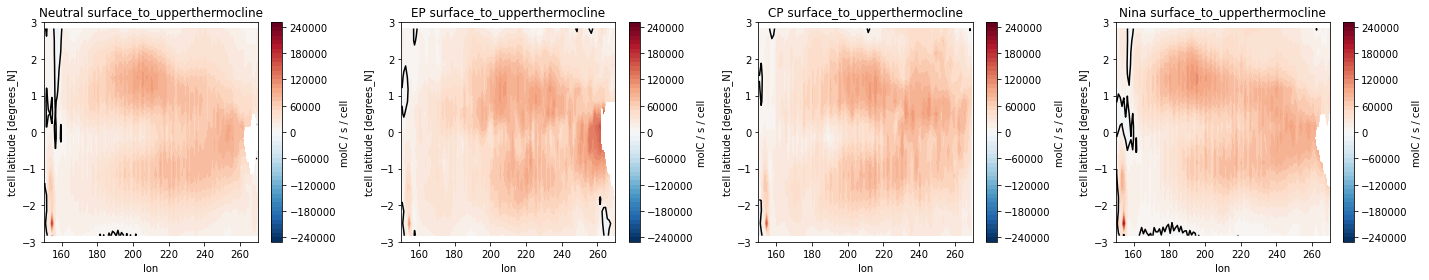

Postive and negative sums [32.48852709 -0.09376152]
Total Sum 32.39476556214113
40457290.1255177
Postive and negative sums [43.15984554 -0.28277018]
Total Sum 42.87707536096775
56684465.046675906
Postive and negative sums [45.55969737 -0.62051114]
Total Sum 44.93918623796239
62410943.7769688
Postive and negative sums [47.57785992 -0.80472796]
Total Sum 46.773131953346834
63625339.10904495
Postive and negative sums [44.48238801 -0.68383782]
Total Sum 43.79855018397963
59636701.78845661


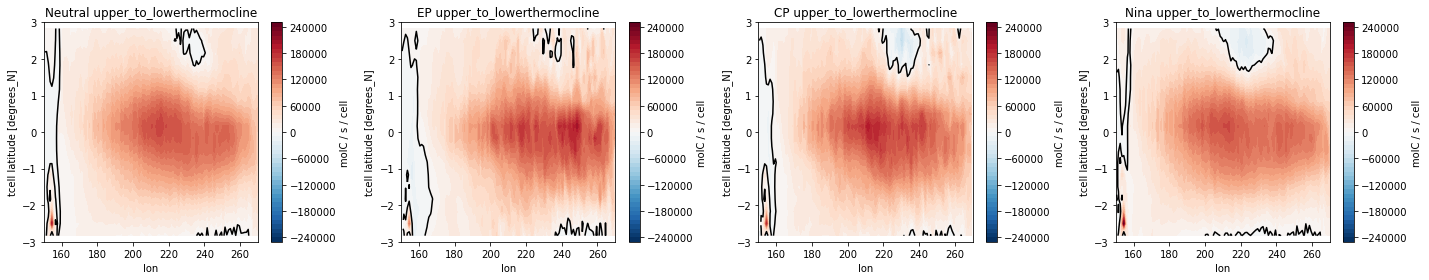

Postive and negative sums [43.97205367 -0.33847924]
Total Sum 43.633574427275235
58097694.79222009
Postive and negative sums [22.52459779 -0.60909598]
Total Sum 21.915501812539738
28574584.353824835
Postive and negative sums [23.91592702 -0.55713281]
Total Sum 23.358794205795824
30441918.38465329
Postive and negative sums [26.96777979 -0.65926232]
Total Sum 26.308517472323146
34211181.288675755
Postive and negative sums [22.64190038 -0.61071382]
Total Sum 22.031186556532653
28504444.62144694


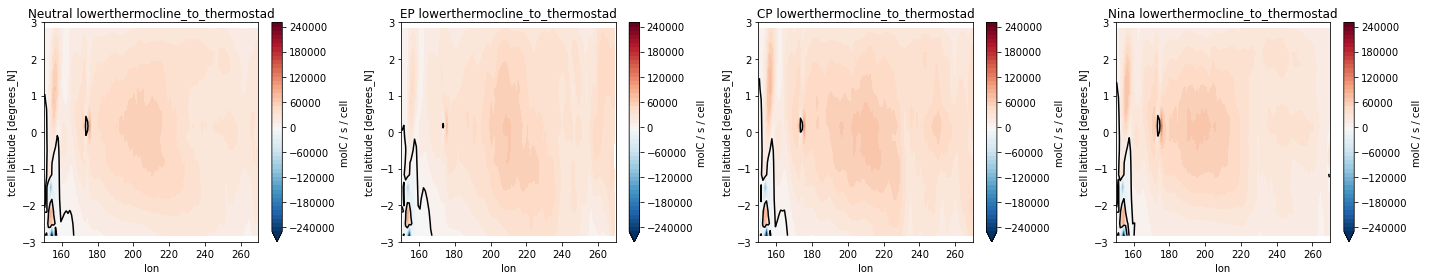

Postive and negative sums [23.13327514 -0.60469414]
Total Sum 22.528580997261237
29304543.888703845
Postive and negative sums [ 0.81381548 -0.00389811]
Total Sum 0.8099173627820108
1030917.2061809755
Postive and negative sums [ 1.02375972 -0.00276989]
Total Sum 1.0209898303551335
1295005.8907252247
Postive and negative sums [ 0.93520409 -0.00170789]
Total Sum 0.933496190965333
1152102.836320174
Postive and negative sums [ 0.81839858 -0.00508539]
Total Sum 0.8133131910664023
1049807.7942252364


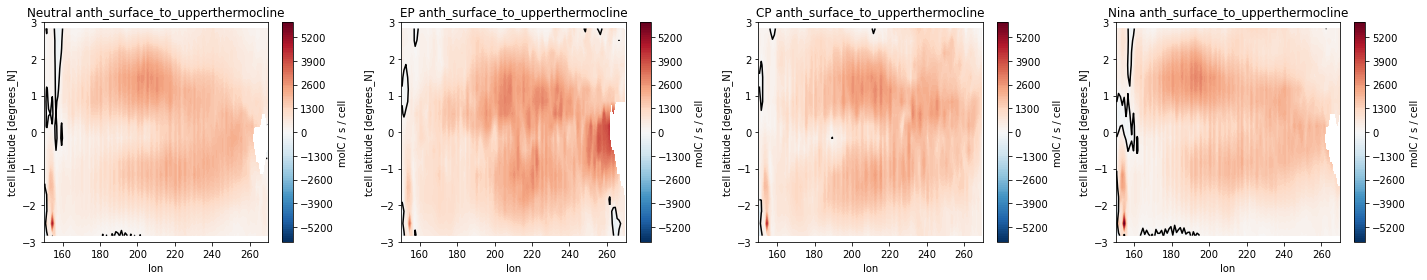

Postive and negative sums [ 0.86246331 -0.00267306]
Total Sum 0.8597902579549688
1075528.2472516983
Postive and negative sums [ 1.11642169 -0.00754349]
Total Sum 1.1088782015609135
1468454.4343172314
Postive and negative sums [ 1.25770387 -0.01781957]
Total Sum 1.2398842933595344
1714007.562636492
Postive and negative sums [ 1.23182559 -0.02176862]
Total Sum 1.2100569699913173
1652323.737364167
Postive and negative sums [ 1.10989978 -0.01769914]
Total Sum 1.0922006398942665
1495609.856144425


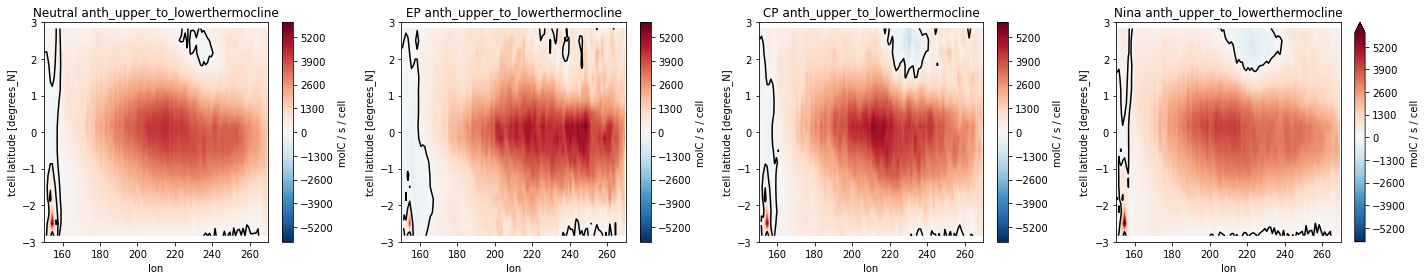

Postive and negative sums [ 1.13088642 -0.00927716]
Total Sum 1.1216092566503473
1494921.3410015972
Postive and negative sums [ 0.3854683  -0.01231025]
Total Sum 0.37315805282154746
489003.02953202795
Postive and negative sums [ 0.41438027 -0.01165123]
Total Sum 0.40272903255485626
526692.0016176536
Postive and negative sums [ 0.46588646 -0.01344636]
Total Sum 0.4524400905028494
591021.0664354741
Postive and negative sums [ 0.3897737  -0.01242771]
Total Sum 0.3773459993089323
491163.6901515175


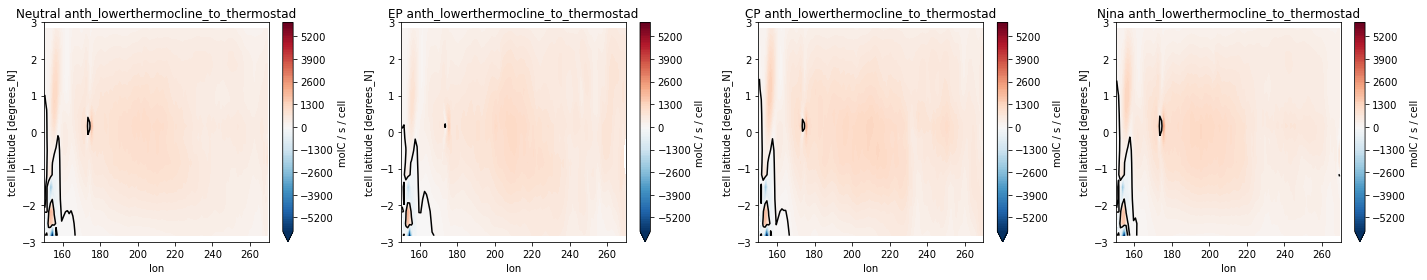

Postive and negative sums [ 0.39753114 -0.01232661]
Total Sum 0.3852045330498379
503580.60978522844
Postive and negative sums [0.16120237 0.        ]
Total Sum 0.16120237112045288
197210.4


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [0.14437595 0.        ]
Total Sum 0.14437595009803772
176625.42
Postive and negative sums [0.15331078 0.        ]
Total Sum 0.15331077575683594
187556.06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [0.15277693 0.        ]
Total Sum 0.15277692675590515
186902.94


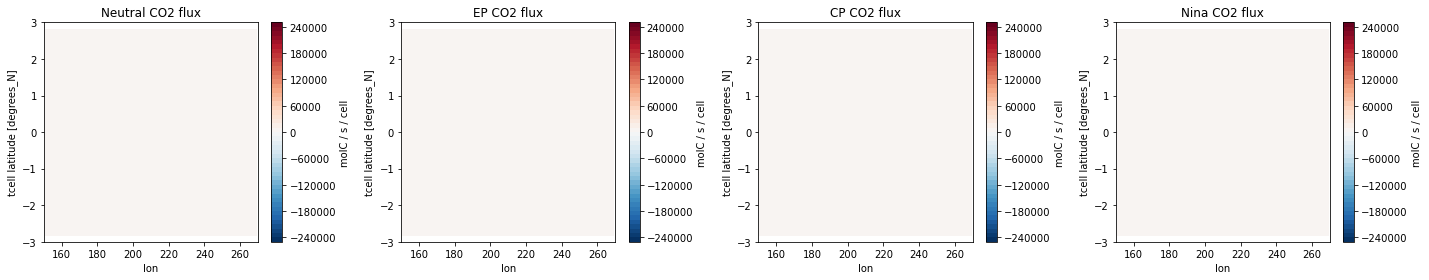

Postive and negative sums [0.15620464 0.        ]
Total Sum 0.15620464086532593
191096.33
Postive and negative sums [ 0.         -0.04449125]
Total Sum -0.044491253793239594
nan


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [ 0.         -0.04328502]
Total Sum -0.04328501969575882
nan
Postive and negative sums [ 0.         -0.04012074]
Total Sum -0.04012073576450348
nan


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [ 0.         -0.04816891]
Total Sum -0.048168912529945374
nan


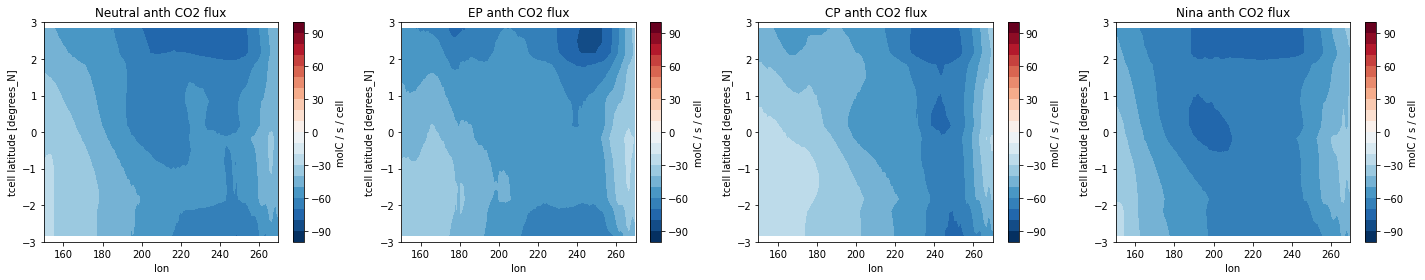

Postive and negative sums [ 0.         -0.04518171]
Total Sum -0.04518170654773712
nan


In [52]:
plot=True

if plot==True:
    density_timefix=cafe_potential_density#.sel(time=enso_months).mean(dim='time')
    #Density FIxed Upwelling??
    contour=[0]
    
    #surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    #anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    
    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_600.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_600.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     
                     surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     anth_surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     flux.sel(time=slice('2000-01-01','2020-01-01')),
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))]
                     
                     #dic_w_tx_dens.sel(density=1023,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1023,method='nearest'),

                     #dic_w_tx_dens.sel(density=1024.5,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1024.5,method='nearest'),

                     #dic_w_tx_dens.sel(density=1026.3, method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1026.3,method='nearest')]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','AnthUpwelling 100','Upwelling 600','AnthUpwelling 600',
               'surface_to_upperthermocline','upper_to_lowerthermocline','lowerthermocline_to_thermostad',
               'anth_surface_to_upperthermocline','anth_upper_to_lowerthermocline','anth_lowerthermocline_to_thermostad',
               'CO2 flux', 'anth CO2 flux']#,'Upwelling 23','Anthropogenic Upwelling 23','Upwelling 24.5','Anthropogenic Upwelling 24.5','Upwelling 26.3','Anthropogenic Upwelling 26.3']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==10:
            levs=np.arange(-300,325,25) #np.arange(-10,11,1)
        if i==11:
            levs=np.arange(-100,110,10) #np.arange(-10,11,1)
        
        elif pd.Series(T_B_names[i]).str.lower().str.contains('600')[0]==True:
            levs=np.arange(-600,610,10)
        elif pd.Series(T_B_names[i]).str.lower().str.contains('anth')[0]==True:
            levs=np.arange(-6000,6100,100)
        elif pd.Series(T_B_names[i]).str.lower().str.contains('anth')[0]==False:
            levs=np.arange(-250000,260000,10000)
        
        
        #if i==0:
        #    levs=None#np.arange(-40,45,5)
         

        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))/1000

        # NEED TO FLIP CO2 FLUX TO OUT OF BOX
        #if pd.Series(T_B_names[i]).str.contains('flux')[0] == True: #==250:
        #    upwelling_dat*=-1 # Calculate Transport OUT of box for flux
        
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'},cmap='RdBu_r') #cmap='bwr' ? is it that?
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat*1000,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'},cmap='RdBu_r')
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat*1000,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'},cmap='RdBu_r')
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat*1000,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'},cmap='RdBu_r')
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat*1000,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

    
    
        plt.tight_layout()
        plt.show()
        
        
        asum_alltime=xarray_posneg_calc(upwelling_dat*1000,enso_months=all_dates,run_density_calc=False)
        #asum_alltime.index=[f'Alltime {E_W_names[i]} at {lon}']
         
        name_str=''
        if pd.Series(T_B_names[i]).str.contains('_to_').iloc[0] ==True:
            if pd.Series(T_B_names[i]).str.contains('anth').iloc[0] ==True:
                name_str='Anth Upwelling'
            else:
                name_str='Upwelling'
        else:
            name_str=T_B_names[i]
            
        temp_holder=pd.DataFrame({f'Neutral {name_str}':asum_neutral,
                                  f'EP {name_str}':asum_ep,
                                  f'CP {name_str}':asum_cp,
                                  f'Nina {name_str}':asum_nina,
                                  f'Alltime {name_str}':asum_alltime},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out']).T #Transpose because i did it backwards
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [53]:
dic_transport_through_box#=dic_transport_through_box[:-8]

,surface_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,Positive Sum above thermostad,Negative Sum above thermostad,Upwelling 100 in,...,anth_surface_to_upperthermocline in,anth_surface_to_upperthermocline out,anth_upper_to_lowerthermocline in,anth_upper_to_lowerthermocline out,anth_lowerthermocline_to_thermostad in,anth_lowerthermocline_to_thermostad out,CO2 flux in,CO2 flux out,anth CO2 flux in,anth CO2 flux out
Neutral Meridional AnthDIC at 3°N,-0.384297,0.183075,0.009280,-0.191943,-0.570982,0.686767,-0.878709,0.654393,-0.851838,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EP Meridional AnthDIC at 3°N,-0.561537,0.180769,0.017322,-0.363446,-0.745824,0.693948,-1.057394,0.657504,-1.024497,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CP Meridional AnthDIC at 3°N,-0.506844,0.178549,0.030558,-0.297736,-0.703720,0.718614,-1.016351,0.675503,-0.993122,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nina Meridional AnthDIC at 3°N,-0.363093,0.184857,-0.001579,-0.179815,-0.550286,0.700367,-0.880182,0.671786,-0.852522,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alltime Meridional AnthDIC at 3°N,-0.395665,0.173428,0.009790,-0.212447,-0.591666,0.682975,-0.895422,0.653375,-0.871692,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Neutral anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.044491254
EP anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.04328502
CP anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.040120736
Nina anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.048168913


In [54]:
dic_transport_through_box.to_csv('dic_tx.csv')

## Check box estimate

In [85]:
(adic_v_s.sum().values*12)/1e18

KeyboardInterrupt: 

In [75]:
(adic_v_s.sum().values*60*60*24*12*30)/1e18

In [86]:
total_sum

<xarray.DataArray ()>
dask.array<add, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0

In [33]:
#Calculate AnthC Box Total

adic_v_s=anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=-3,method='nearest')
dic_v_s=dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=-3,method='nearest')

adic_v_n=anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=3,method='nearest')
dic_v_n=dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=slice(160,250)).sel(lat=3,method='nearest')

adic_u_w=anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=160,method='nearest').sel(lat=slice(-3,3))
dic_u_w=dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=160,method='nearest').sel(lat=slice(-3,3))

adic_u_e=-anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=250,method='nearest').sel(lat=slice(-3,3))
dic_u_e=-dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)).sel(lon=250,method='nearest').sel(lat=slice(-3,3))

up600=upwelling_600.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))
aup600=anthupwelling_600.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))

outsurf=flux.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))
aoutsurf=anthflux.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-3,3),lon=slice(160,250))

total_sum=adic_v_s.sum()+adic_v_n.sum()+adic_u_w.sum()+adic_u_e.sum()+aup600.sum()+aoutsurf.sum()
print(total_sum.values)
(total_sum.values*60*60*24*(365/12)*12)/1e18 #mmolC /S /cell -> minute -> hour -> day -> month _> mgrams - > pgrams
# Doesnt line up with below number out by an order of mag or 2. 

157074310000.0


4.95349541240832

In [139]:
aoutsurf

<xarray.DataArray (time: 240, lat: 18, lon: 170)>
array([[[        nan,         nan, -16554.467 , ...,         nan,
                 nan,         nan],
        [        nan,         nan, -16492.684 , ...,         nan,
                 nan,         nan],
        [        nan,         nan, -16901.965 , ...,         nan,
                 nan,         nan],
        ...,
        [-57540.09  , -60569.492 , -61471.703 , ...,         nan,
                 nan,         nan],
        [-63087.53  , -65304.965 , -64613.984 , ...,         nan,
                 nan,         nan],
        [-68588.31  , -68819.11  , -67619.945 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan, -10953.908 , ...,         nan,
                 nan,         nan],
        [        nan,         nan, -10835.794 , ...,         nan,
                 nan,         nan],
        [        nan,         nan, -11168.747 , ...,         nan,
                 nan,         nan],
...
        [-40955.83  , -40809.863 , -38197.516 , ...,         nan,
                 nan,         nan],
        [-41655.13  , -43556.58  , -42884.855 , ...,         nan,
                 nan,         nan],
        [-41694.418 , -44470.797 , -45721.395 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,  -5011.8154, ...,         nan,
                 nan,         nan],
        [        nan,         nan,  -5623.2446, ...,         nan,
                 nan,         nan],
        [        nan,         nan,  -6615.96  , ...,         nan,
                 nan,         nan],
        ...,
        [-25042.145 , -27829.955 , -28998.17  , ...,         nan,
                 nan,         nan],
        [-24522.93  , -27517.92  , -29553.262 , ...,         nan,
                 nan,         nan],
        [-24535.723 , -27786.27  , -30123.867 , ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -2.833 -2.5 -2.166 -1.834 ... 1.834 2.166 2.5 2.833

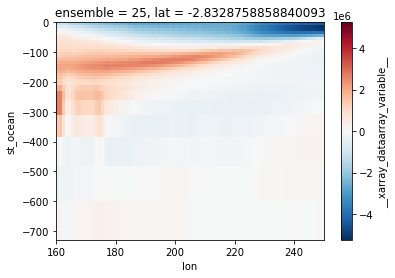

In [48]:
adic_v_s.mean(dim='time').plot()#sel(lat=3,method='nearest').plot()

In [66]:
est=pd.DataFrame(((df).pivot(columns='enso_phase')).sum(axis=0)).unstack(level=-1).sum()
est*20

   enso_phase
0  Alltime       1.66
   CP           -1.18
   EP           -4.24
   Neutral       1.84
   Nina          3.62
dtype: float64

In [62]:
(((adic_u_e.mean(dim='time').sum().values)*60*60*24*365*12)/1e18) # Two different ways of calculating eastern u sum and mean * 365 days * 20 years vs sum (*30 days)

-0.193649249138688

In [43]:
(adic_u_e.sum().values*60*60*24*(365/12)*12)/1e18

-3.889122873311232

In [153]:
print((adic_v_s.sum().values*60*60*24*(365/12)*12)/1e18)
print((adic_v_n.sum().values*60*60*24*(365/12)*12)/1e18)
print((adic_u_w.sum().values*60*60*24*(365/12)*12)/1e18)
print((adic_u_e.sum().values*60*60*24*(365/12)*12)/1e18)
print((aup600.sum().values*60*60*24*(365/12)*12)/1e18)
print((aoutsurf.sum().values*60*60*24*(365/12)*12)/1e18)

-0.700432607674368
4.021833885548544
5.85581745143808
-3.889122873311232
0.3765127693202483
-0.71111276199936


In [144]:
-0.700432607674368+\
4.021833885548544+\
5.85581745143808+\
-3.889122873311232+\
0.3765127693202483+\
-0.71111276199936

4.953495863321912

In [145]:
tot_anth_dic_cafe

<xarray.DataArray (time: 731, st_ocean: 50, lat: 140, lon: 170)>
dask.array<truediv, shape=(731, 50, 140, 170), dtype=float64, chunksize=(87, 50, 70, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat         (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0

In [ ]:
# Is the Amount of anth C accumulated in the box over the 20 years. (mmol anth C)
diff=tot_anth_dic_cafe.sel(time='2020-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,700),lon=slice(160,250)).sum().values-\
    tot_anth_dic_cafe.sel(time='2000-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,700),lon=slice(160,250)).sum().values# Total mol anthC 
print(diff)
(diff*12)/1e15 #Petagrams total change

38785829972394.125


0.4654299596687295

## End Box Estimate

In [55]:
region=''#'_big'
dic_transport_through_box = pd.read_csv(f'dic_tx{region}.csv',index_col=0)


In [56]:
dic_transport_through_box

,surface_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,Positive Sum above thermostad,Negative Sum above thermostad,Upwelling 100 in,...,anth_surface_to_upperthermocline in,anth_surface_to_upperthermocline out,anth_upper_to_lowerthermocline in,anth_upper_to_lowerthermocline out,anth_lowerthermocline_to_thermostad in,anth_lowerthermocline_to_thermostad out,CO2 flux in,CO2 flux out,anth CO2 flux in,anth CO2 flux out
Neutral Meridional AnthDIC at 3°N,-0.384297,0.183075,0.009280,-0.191943,-0.570982,0.686767,-0.878710,0.654393,-0.851838,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EP Meridional AnthDIC at 3°N,-0.561537,0.180769,0.017322,-0.363446,-0.745824,0.693948,-1.057394,0.657505,-1.024497,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CP Meridional AnthDIC at 3°N,-0.506844,0.178549,0.030558,-0.297736,-0.703720,0.718614,-1.016350,0.675503,-0.993122,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nina Meridional AnthDIC at 3°N,-0.363093,0.184857,-0.001579,-0.179815,-0.550286,0.700367,-0.880182,0.671786,-0.852522,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alltime Meridional AnthDIC at 3°N,-0.395665,0.173428,0.009790,-0.212447,-0.591666,0.682975,-0.895422,0.653375,-0.871692,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Neutral anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.044491
EP anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.043285
CP anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.040121
Nina anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.048169


In [57]:
# Bit of Data Wrangling

In [103]:
# NEW VERSION

region=''#'_big'
dic_transport_through_box = pd.read_csv(f'dic_tx{region}.csv',index_col=0)

#dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['Upwelling 100 in']+dic_transport_through_box['Upwelling 100 out'])
#dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['AnthUpwelling 100 in']+dic_transport_through_box['AnthUpwelling 100 out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(
    dic_transport_through_box['surface_to_upperthermocline in']+dic_transport_through_box['surface_to_upperthermocline out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(
    dic_transport_through_box['anth_surface_to_upperthermocline in']+dic_transport_through_box['anth_surface_to_upperthermocline out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])


#dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
#   dic_transport_through_box['upper_to_lowerthermocline in']+dic_transport_through_box['upper_to_lowerthermocline out'])
#dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
#    dic_transport_through_box['anth_upper_to_lowerthermocline in']+dic_transport_through_box['anth_upper_to_lowerthermocline out'])


dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['lowerthermocline_to_thermostad in']+dic_transport_through_box['lowerthermocline_to_thermostad out'])

dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['anth_lowerthermocline_to_thermostad in']+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])


# Surface now = Anywhere above 24.5

#Total Sum 	Total Sum 100m 	Positive Sum 	Negative Sum

# Total is 600M + and NEG
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])

dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['AnthUpwelling 600 in']+dic_transport_through_box['AnthUpwelling 600 out'])
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['Upwelling 600 in']+dic_transport_through_box['Upwelling 600 out'])
    


dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['AnthUpwelling 600 in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['Upwelling 600 in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])


#Positive Sum above thermostad
#Negative Sum above thermostad


dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['anth CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['Upwelling 600 out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['AnthUpwelling 600 out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])


    
# Need to do some calculations to fill the Positive Sum above thermocline and above thermostad ['Negative Sum']
# Also need to reverse some of the directions (ie E pacific?)
    
dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 100 in','Upwelling 100 out','AnthUpwelling 100 in','AnthUpwelling 100 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)

dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 600 in','Upwelling 600 out','AnthUpwelling 600 in','AnthUpwelling 600 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['surface_to_upperthermocline in','surface_to_upperthermocline out','anth_surface_to_upperthermocline in','anth_surface_to_upperthermocline out','upper_to_lowerthermocline in','upper_to_lowerthermocline out','anth_upper_to_lowerthermocline in','anth_upper_to_lowerthermocline out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['lowerthermocline_to_thermostad in','lowerthermocline_to_thermostad out','anth_lowerthermocline_to_thermostad in','anth_lowerthermocline_to_thermostad out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['CO2 flux in','CO2 flux out','anth CO2 flux in','anth CO2 flux out'],axis=1)
dic_transport_through_box=dic_transport_through_box.dropna(thresh=1)

dic_transport_through_box.to_csv(f'dic_tx2{region}.csv')

t=pd.read_csv(f'dic_tx2{region}.csv').replace(0,np.nan)
merged=t.groupby('Unnamed: 0').mean().sort_values('Unnamed: 0').round(3)#agg(np.mean())

merged['enso_phase']=merged.index.str.split(' ').str[0]
merged.index=merged.index.str.split(' ').str[1:].str.join(' ')#.groupby('surface_sum')

merged.to_csv(f'dic_tx3{region}.csv')
merged

,surface_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,Positive Sum above thermostad,Negative Sum above thermostad,enso_phase
Unnamed: 0,,,,,,,,,,
Anth Upwelling,0.860,0.385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alltime
AnthUpwelling 600,NaN,NaN,NaN,0.022,NaN,0.025,-0.003,NaN,NaN,Alltime
CO2 flux,0.156,NaN,NaN,0.156,NaN,0.156,NaN,NaN,NaN,Alltime
Meridional AnthDIC at 3°N,-0.396,0.173,0.010,-0.212,-0.592,0.683,-0.895,0.653,-0.872,Alltime
Meridional AnthDIC at 3°S,-0.128,0.267,0.078,0.216,-0.540,1.002,-0.786,0.934,-0.764,Alltime
...,...,...,...,...,...,...,...,...,...,...
Zonal AnthDIC at 110°W,0.098,-0.300,-0.015,-0.217,-0.089,0.102,-0.320,0.100,-0.318,Nina
Zonal AnthDIC at 160°E,-0.122,0.297,0.171,0.346,-0.254,0.643,-0.297,0.552,-0.297,Nina
Zonal DIC at 110°W,4.058,-15.376,-1.713,-13.031,-4.872,4.303,-17.333,4.157,-16.874,Nina


In [52]:
# Prepare Data for Plotting
region=''
dic_transport_through_box=pd.read_csv(f'dic_tx3{region}.csv',index_col=0).replace(0,np.nan)

names=dic_transport_through_box.index

new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)
        
    

Positive Sum                               \
enso_phase                     Alltime     CP     EP Neutral   Nina   
Unnamed: 0                                                            
Anth Upwelling                     NaN    NaN    NaN     NaN    NaN   
AnthUpwelling 600                0.025  0.034  0.049   0.024  0.020   
Meridional AnthDIC at 3°N        0.683  0.719  0.694   0.687  0.700   
Meridional AnthDIC at 3°S        1.002  0.972  0.945   0.981  1.089   
Zonal AnthDIC at 110°W           0.115  0.146  0.155   0.116  0.102   
Zonal AnthDIC at 160°E           0.621  0.613  0.527   0.629  0.643   
anth CO2 flux                      NaN    NaN    NaN     NaN    NaN   

                          Negative Sum                               
enso_phase                     Alltime     CP     EP Neutral   Nina  
Unnamed: 0                                                           
Anth Upwelling                     NaN    NaN    NaN     NaN    NaN  
AnthUpwelling 600               -0.003 -0.004 -0.004  -0.004 -0.003  
Meridional AnthDIC at 3°N       -0.895 -1.016 -1.057  -0.879 -0.880  
Meridional AnthDIC at 3°S       -0.786 -0.769 -0.792  -0.786 -0.825  
Zonal AnthDIC at 110°W          -0.306 -0.287 -0.297  -0.307 -0.320  
Zonal AnthDIC at 160°E          -0.328 -0.427 -0.389  -0.325 -0.297  
anth CO2 flux                   -0.045 -0.040 -0.043  -0.044 -0.048

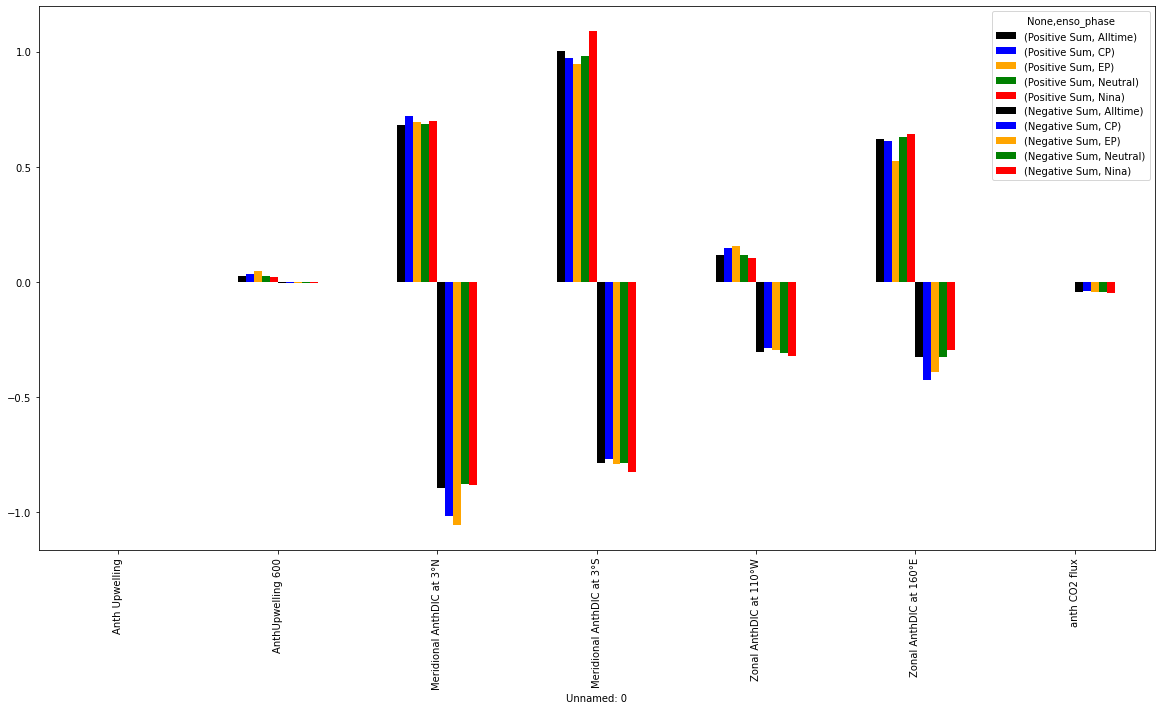

In [53]:
fig=plt.figure(figsize=(20,10))
ax=plt.subplot(111)
df=new_tx_anth[['Positive Sum','Negative Sum','enso_phase']]
df.groupby('enso_phase').sum()#
df.pivot(columns='enso_phase').plot.bar(ax=ax,color=['Black','Blue','Orange','Green','Red'])
df.pivot(columns='enso_phase')

In [54]:
est=pd.DataFrame((df.pivot(columns='enso_phase')*20).sum(axis=0)).unstack(level=-1).sum()

In [176]:
est

   enso_phase
0  Alltime       1.66
   CP           -1.18
   EP           -4.24
   Neutral       1.84
   Nina          3.62
dtype: float64

   enso_phase
0  Alltime       1.66
   CP           -1.18
   EP           -4.24
   Neutral       1.84
   Nina          3.62
dtype: float64

In [116]:
48.92+-47.26

1.6600000000000037

In [ ]:
new_tx_anth['Positive Sum']

In [ ]:
new_tx_anth.columns[:-1]

In [ ]:

# Plotting
#plt.figure(figsize=(16,16))
#for i,col in enumerate(new_tx.columns[:-1]):
#    ax=plt.subplot(5,2,i+1)
#    df=new_tx[[col,'enso_phase']]#.plot.bar()
#    df.pivot(columns='enso_phase').dropna(thresh=1).plot.bar(ax=ax)#plt.show()
#    #df.drop('Upwelling 100').groupby('enso_phase').sum().T['EP'].values
#    sum_of_rows=df.groupby('enso_phase').sum()#.drop('Upwelling 100').
#    #print(sum_of_rows
#    plt.title(col)
#    plt.xticks(rotation=45)
#    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
#            f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
##            f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
#            f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything
#plt.tight_layout()


# Plotting Anth
plt.figure(figsize=(16,16))
for i, col in enumerate(new_tx_anth.columns[:-1]):
    ax=plt.subplot(5,2,i+1)
    df=new_tx_anth[[col,'enso_phase']]#.plot.bar()
    
    
    # CAN WE SOMEHOW MODIFY BAR COLOURS HERE?
    df.pivot(columns='enso_phase').plot.bar(ax=ax,color=['Blue','Orange','Green','Red','Black'])#plt.show()
    #plt.legend(['CP','EP','Neutral','Nina'])# Make sure this doesnt break anything
    plt.title(col)
    sum_of_rows=df.groupby('enso_phase').sum()#
    #print(sum_of_rows)
    plt.xticks(rotation=45)
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
                f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
                f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
                f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC',
                f'Alltime {sum_of_rows.T["Alltime"].values[0].round(4)}PgC'])# Make sure this doesnt break anything
plt.tight_layout()

In [ ]:
dic_transport_through_box.columns

In [ ]:
region=''#'_big'
dic_transport_through_box = pd.read_csv(f'dic_tx{region}.csv',index_col=0)

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['Upwelling 100 in']+dic_transport_through_box['Upwelling 100 out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['AnthUpwelling 100 in']+dic_transport_through_box['AnthUpwelling 100 out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(
    dic_transport_through_box['surface_to_upperthermocline in']+dic_transport_through_box['surface_to_upperthermocline out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(
    dic_transport_through_box['anth_surface_to_upperthermocline in']+dic_transport_through_box['anth_surface_to_upperthermocline out'])


dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['upper_to_lowerthermocline in']+dic_transport_through_box['upper_to_lowerthermocline out'])
dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['anth_upper_to_lowerthermocline in']+dic_transport_through_box['anth_upper_to_lowerthermocline out'])

dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['lowerthermocline_to_thermostad in']+dic_transport_through_box['lowerthermocline_to_thermostad out'])

dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['anth_lowerthermocline_to_thermostad in']+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])

#Total Sum 	Total Sum 100m 	Positive Sum 	Negative Sum
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['anth CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])


dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['anth_upper_to_lowerthermocline in']+dic_transport_through_box['anth_upper_to_lowerthermocline out'])
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['upper_to_lowerthermocline in']+dic_transport_through_box['upper_to_lowerthermocline out'])
    
    
    
# Need to do some calculations to fill the Positive Sum above thermocline and above thermostad ['Negative Sum']
# Also need to reverse some of the directions (ie E pacific?)
    
dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 100 in','Upwelling 100 out','AnthUpwelling 100 in','AnthUpwelling 100 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)

dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 500 in','Upwelling 500 out','AnthUpwelling 500 in','AnthUpwelling 500 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['surface_to_upperthermocline in','surface_to_upperthermocline out','anth_surface_to_upperthermocline in','anth_surface_to_upperthermocline out','upper_to_lowerthermocline in','upper_to_lowerthermocline out','anth_upper_to_lowerthermocline in','anth_upper_to_lowerthermocline out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['lowerthermocline_to_thermostad in','lowerthermocline_to_thermostad out','anth_lowerthermocline_to_thermostad in','anth_lowerthermocline_to_thermostad out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['CO2 flux in','CO2 flux out','anth CO2 flux in','anth CO2 flux out'],axis=1)
dic_transport_through_box=dic_transport_through_box.dropna(thresh=1)

dic_transport_through_box.to_csv(f'dic_tx2{region}.csv')

t=pd.read_csv(f'dic_tx2{region}.csv').replace(0,np.nan)
merged=t.groupby('Unnamed: 0').mean().sort_values('Unnamed: 0').round(3)#agg(np.mean())

merged['enso_phase']=merged.index.str.split(' ').str[0]
merged.index=merged.index.str.split(' ').str[1:].str.join(' ')#.groupby('surface_sum')

merged.to_csv(f'dic_tx3{region}.csv')
merged



# Prepare Data for Plotting
dic_transport_through_box=pd.read_csv(f'dic_tx3{region}.csv',index_col=0).replace(0,np.nan)

names=dic_transport_through_box.index

new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)
        
    
# Plotting
plt.figure(figsize=(16,16))
for i,col in enumerate(new_tx.columns[:-1]):
    ax=plt.subplot(4,2,i+1)
    df=new_tx[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar(ax=ax)#plt.show()
    #df.drop('Upwelling 100').groupby('enso_phase').sum().T['EP'].values
    sum_of_rows=df.drop('Upwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows
    plt.title(col)
    plt.xticks(rotation=45)
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
            f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
            f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
            f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything
plt.tight_layout()
# Plotting Anth
plt.figure(figsize=(16,16))
for i, col in enumerate(new_tx_anth.columns[:-1]):
    ax=plt.subplot(4,2,i+1)
    df=new_tx_anth[[col,'enso_phase']]#.plot.bar()
    
    
    # CAN WE SOMEHOW MODIFY BAR COLOURS HERE?
    df.pivot(columns='enso_phase').plot.bar(ax=ax)#plt.show()
    #plt.legend(['CP','EP','Neutral','Nina'])# Make sure this doesnt break anything
    plt.title(col)
    sum_of_rows=df.drop('AnthUpwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows)
    plt.xticks(rotation=45)
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
                f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
                f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
                f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything
plt.tight_layout()

In [ ]:
new_tx

In [ ]:
for col in new_tx.columns[:-1]:
    df=new_tx[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()
    #df.drop('Upwelling 100').groupby('enso_phase').sum().T['EP'].values
    sum_of_rows=df.drop('Upwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows
    plt.title(col)
    
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
            f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
            f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
            f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything

In [ ]:
for col in new_tx_anth.columns[:-1]:
    df=new_tx_anth[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()
    #plt.legend(['CP','EP','Neutral','Nina'])# Make sure this doesnt break anything
    plt.title(col)
    sum_of_rows=df.drop('AnthUpwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows)
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
                f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
                f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
                f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything

In [ ]:
new_tx_anth.index.str.split(' ').str[0]#.groupby('surface_sum')

In [ ]:
new_tx.index.str.split(' ').str[2]#.groupby('surface_sum')

In [ ]:
new_tx.index.str.split(' ').str[3]#.groupby('surface_sum')


In [ ]:
df=new_tx[[col,'enso_phase']]#set_index(['Unnamed: 0'])#.stack()

In [ ]:
#.groupby('enso_phase')[col].apply(list)
#df#.apply(pd.Series)

In [ ]:
grouper = df.groupby('enso_phase')
df = pd.concat([pd.Series(v[col].tolist(), name=k) for k, v in grouper], axis=1)

In [ ]:
new_tx#df

In [ ]:
dat=new_tx[[col,'enso_phase']]
dat.where(dat['enso_phase']=='CP').plot.bar()

In [ ]:
new_tx.groupby('enso_phase').plot.bar()

In [ ]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
new_tx

In [ ]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling 500','upwelling 700','upwelling 100','flux']
box_faces=['3s','3n','160','250','upwelling 700','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
        
    plt.figure(figsize=(12,8))
    ax=plt.subplot(111)
    box_res.plot.bar(ax=ax)
    plt.axhline(0,c='k')
    plt.show()
    
    print(box_res)
    #plt.figure(figsize=(12,5))
    print(box_res.mean())
    box_res.mean().plot.bar()
    plt.axhline(0,c='k')
    plt.show()

In [ ]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth

In [ ]:
# Old Upwelling Estimates

plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_700.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_700.sel(time=slice('2000-01-01','2020-01-01')),

                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','Anthropogenic Upwelling 100','Upwelling 500','Anthropogenic Upwelling 500','Upwelling 700','Anthropogenic Upwelling 700','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')


